In [50]:
import scipy as sp
import statsmodels.api as sm
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import scanpy as sc
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
from persim import plot_diagrams 
from ripser import ripser, lower_star_img
from sklearn.cluster import KMeans
from numpy import histogram


In this experiment I use a set of 100 Gaussian PDFs clustered in groups of 20 according to their mean value $\mu$

In [130]:
rng = np.random.default_rng()
#initialise synthetic dataframe
n_pdfs=100
x_size=1000

X=np.zeros([n_pdfs,x_size]) #Whole sample dataset
var=2*rng.random(size=n_pdfs)
mu=np.zeros(n_pdfs)
j=1
for i in range(0,n_pdfs):
    mu[i]=j
    if (i+1)%20==0:
        j=j+1
        
for i in range(0,n_pdfs):
    aux = rng.normal(loc=mu[i], scale = var[i], size=x_size)
    X[i,:] = aux

100


In [142]:
#Build distance matrix
batch_size_features= X.shape[0]
Mw_matrix = np.zeros((batch_size_features,batch_size_features)) #w distance matrix

for col_i in range(0,batch_size_features):
    for col_j in range(col_i,batch_size_features):
        Mw_matrix[col_i,col_j] = wasserstein_distance(X[col_i,:]
                                                      ,X[col_j,:])

Mw_matrix= Mw_matrix+Mw_matrix.T-np.diag(np.diag(Mw_matrix))

Text(0.5, 1.0, 'Wasserstein distances matrix')

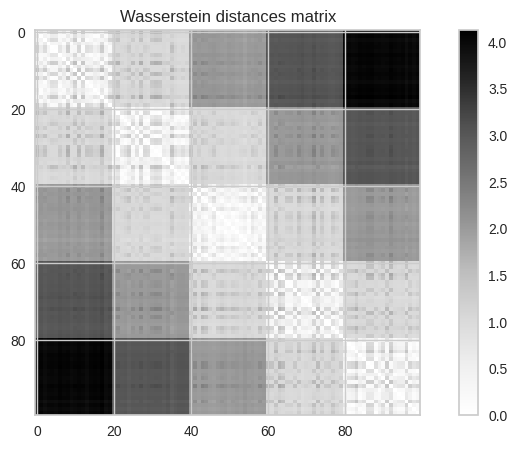

In [143]:
dgm = lower_star_img(Mw_matrix)
plt.figure(figsize=(10, 5))
#plt.subplot(121)
plt.imshow(Mw_matrix)
plt.colorbar()
plt.title("Wasserstein distances matrix")

Checking using hdbscan clustering algorithm
https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [145]:
import hdbscan
clusterer = hdbscan.HDBSCAN(algorithm='best',metric='precomputed',min_cluster_size=5)
clusterer.fit(Mw_matrix)
#evaluating clustering
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(labels_true = mu, labels_pred = clusterer.labels_)
print('The Score index is', round(rand_index, 2))

The Score index is 1.0


Clustering using MDS and then Kmeans

Text(0.5, 0, 'Dimension')

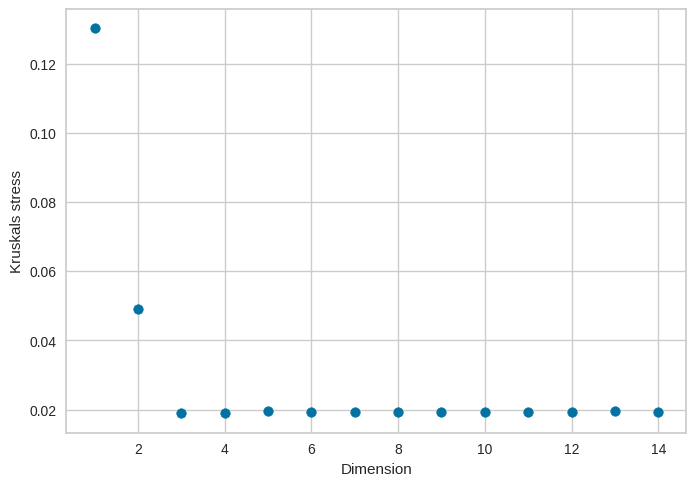

In [146]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
s,si=[],[]
stress1,i=1,1
while i<15:
    mds = MDS(n_components=i,dissimilarity='precomputed', random_state=0, normalized_stress='auto')
    # Get the embeddings
    X_transform = mds.fit_transform(Mw_matrix)
    ## Kruskal's stress (or stress formula 1)
    DE = euclidean_distances(X_transform)
    stress = 0.5 * np.sum((DE - Mw_matrix)**2)
    stress1=np.sqrt(stress / (0.5 * np.sum(Mw_matrix**2)))
    s.append(stress1)
    si.append(i)
    i=i+1
plt.scatter(si,s)
plt.ylabel('Kruskals stress')
plt.xlabel('Dimension')

In [155]:
mds = MDS(n_components=3,dissimilarity='precomputed',
          random_state=0, normalized_stress='auto')
# Get the embeddings
X_transform = mds.fit_transform(Mw_matrix)

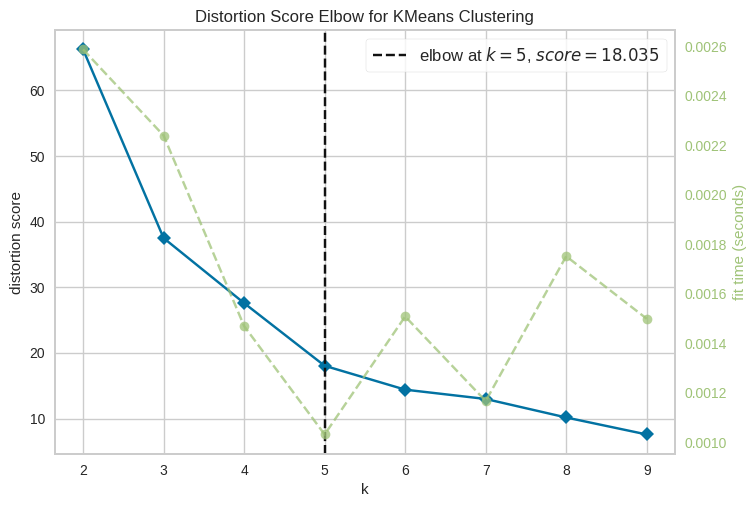

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [156]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=0,n_init='auto')
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(X_transform)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<Axes: >

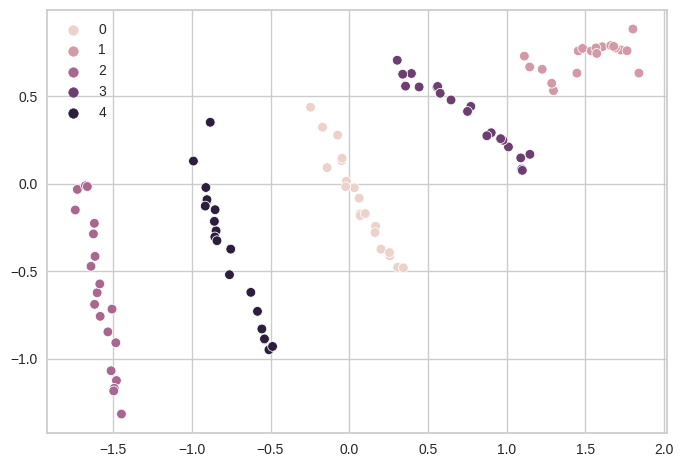

In [157]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

kmeans_model = KMeans(n_clusters = 5,n_init='auto')
kmeans_model.fit(X_transform)
sns.scatterplot(x=X_transform[:,0],y=X_transform[:,1],hue=kmeans_model.labels_)

In [159]:
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(labels_true = mu, labels_pred = kmeans_model.labels_)
print('The Score index is', round(rand_index, 2))

The Score index is 1.0
